In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import anndata2ri
import logging

import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro
import rpy2.robjects.packages as rpackages

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

In [3]:
import numpy as np 
import scanpy as sc
import scipy
import scanorama
import pandas as pd 
import matplotlib.pyplot as plt
import anndata as ad
from scipy.sparse import csr_matrix, issparse

In [4]:
%%R
library(BiocParallel)
library(anndata)
library(scran)


    consider that it could be called from a Python process. This
    results in a quasi-obligatory segfault when rpy2 is evaluating
    R code using it. On the hand, rpy2 is accounting for the
    fact that it might already be running embedded in a Python
    process. This is why:
    - Python -> rpy2 -> R -> reticulate: crashes
    - R -> reticulate -> Python -> rpy2: works

    The issue with reticulate is tracked here:
    https://github.com/rstudio/reticulate/issues/208
    

# Scanorama

In [5]:
# Data set: Ribo-hb geneges were removed.

# adata = sc.read("/home/ubuntu/scib-pipeline/data/Concatenated_E55_pseudoT_RMhb_RMrebo.h5ad")
# adata.obs.rename(columns = {"CellType_merged":"Cell_Type"},inplace=True)
# adata.X = adata.layers["counts"]
# unintegrated_data = adata.copy()

In [6]:
#Data set: Not filtered alldata 

adata = sc.read("/dev/shm/backup/Concatenated_E55_pseudoT.h5ad")
adata.obs.rename(columns = {"CellType_merged":"Cell_Type"},inplace=True)
adata.X = adata.layers["counts"]
unintegrated_data = adata.copy()

In [7]:
adata

AnnData object with n_obs × n_vars = 12195 × 15456
    obs: 'cell_type', 'batch_id', 'batch', 'Cell_Type', 'n_genes', 'n_counts', 'dpt_pseudotime'
    var: 'rebo', 'hb', 'gene_symbol-0', 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'highly_variable-1', 'means-1', 'dispersions-1', 'dispersions_norm-1', 'highly_variable-2', 'means-2', 'dispersions-2', 'dispersions_norm-2', 'highly_variable-3', 'means-3', 'dispersions-3', 'dispersions_norm-3', 'highly_variable-4', 'means-4', 'dispersions-4', 'dispersions_norm-4', 'highly_variable-5', 'means-5', 'dispersions-5', 'dispersions_norm-5', 'highly_variable-6', 'means-6', 'dispersions-6', 'dispersions_norm-6'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'

In [9]:
adata.obs.Cell_Type.value_counts()

EPI    8133
ExE    2605
VE     1457
Name: Cell_Type, dtype: int64

In [10]:
# Separating data sets as Scanorama requires. 

batches = adata.obs['batch_id'].unique().tolist()
alldata = {}
for batch in batches:
    alldata[batch] = adata[adata.obs['batch_id'] == batch,]

## Scanorama with Scanpy Normalization

- Scanpy Total Count Normalization.

In [11]:
# While working on anndata object as a values of a dictionary, anndata_dict.copy() doesn't prevent changement in the original dict.
# Followed line does.
alldata_norm = {key: adata.copy() for key, adata in alldata.items()}

In [12]:
# Since we will apply the same steps after normalization, defininig a function would be helpfull

def scanorama_umap(adatas):
    corrected = scanorama.correct_scanpy(adatas, return_dimred=True)
    concat_data = ad.concat(corrected, join = 'inner')
    sc.pp.neighbors(concat_data, use_rep="X_scanorama")
    sc.tl.umap(concat_data)
    sc.tl.leiden(concat_data, key_added="clusters")
    #sc.set_figure_params(figsize=(6, 6))
    # sc.pl.umap(concat_data, color=["clusters", "batch_id","CellType_merged"], ncols=3,wspace=0.35)
    return corrected, concat_data

- Scaling was a crutial step for our task for Scanorama.

In [13]:
# sc.pp.scale(adata, max_value=10)

for i,adata in enumerate(alldata_norm.values()):
    sc.pp.normalize_total(adata, target_sum=1e6)
    sc.pp.log1p(adata)
    sc.pp.scale(adata, max_value=10)

In [14]:
adatas =list(alldata_norm.values())
adatas

[AnnData object with n_obs × n_vars = 269 × 15456
     obs: 'cell_type', 'batch_id', 'batch', 'Cell_Type', 'n_genes', 'n_counts', 'dpt_pseudotime'
     var: 'rebo', 'hb', 'gene_symbol-0', 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'highly_variable-1', 'means-1', 'dispersions-1', 'dispersions_norm-1', 'highly_variable-2', 'means-2', 'dispersions-2', 'dispersions_norm-2', 'highly_variable-3', 'means-3', 'dispersions-3', 'dispersions_norm-3', 'highly_variable-4', 'means-4', 'dispersions-4', 'dispersions_norm-4', 'highly_variable-5', 'means-5', 'dispersions-5', 'dispersions_norm-5', 'highly_variable-6', 'means-6', 'dispersions-6', 'dispersions_norm-6', 'mean', 'std'
     uns: 'log1p'
     obsm: 'X_pca', 'X_umap'
     layers: 'counts',
 AnnData object with n_obs × n_vars = 2072 × 15456
     obs: 'cell_type', 'batch_id', 'batch', 'Cell_Type', 'n_genes', 'n_counts', 'dpt_pseudotime'
     var: 'rebo', 'hb', 'gene_symbol-0', 'highly_variable-0', 'means-0', 'dispersio

In [15]:
scanorama_result = scanorama_umap(adatas)

Found 15456 genes among all datasets
[[0.         0.7063197  0.20817844 0.16356877 0.69642857 0.43122677]
 [0.         0.         0.94160232 0.6023166  0.42261905 0.01190476]
 [0.         0.         0.         0.84544739 0.41071429 0.02380952]
 [0.         0.         0.         0.         0.58928571 0.25396825]
 [0.         0.         0.         0.         0.         0.50793651]
 [0.         0.         0.         0.         0.         0.        ]]
Processing datasets (1, 2)
Processing datasets (2, 3)
Processing datasets (0, 1)
Processing datasets (0, 4)
Processing datasets (1, 3)
Processing datasets (3, 4)
Processing datasets (4, 5)
Processing datasets (0, 5)
Processing datasets (1, 4)
Processing datasets (2, 4)
Processing datasets (3, 5)
Processing datasets (0, 2)
Processing datasets (0, 3)


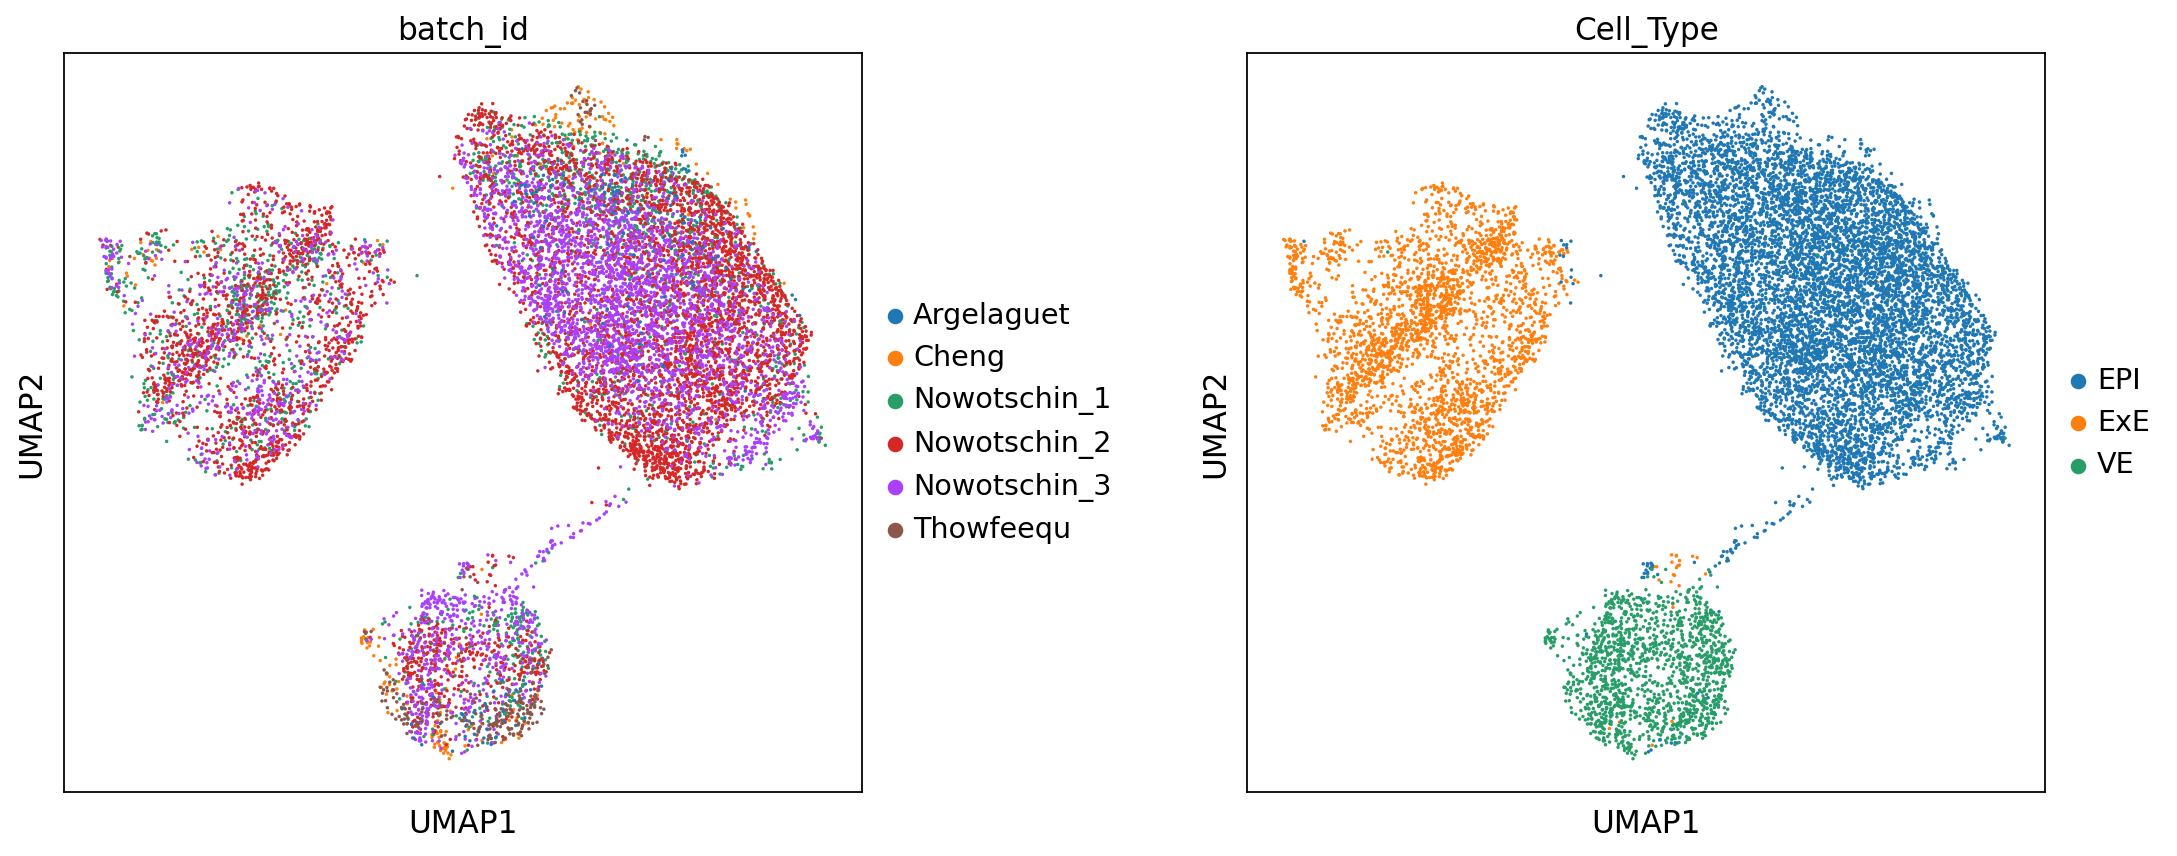

In [16]:
scanorama_integ_scanpy_data = scanorama_result[1]
corrected = scanorama_result[0]
sc.set_figure_params(figsize=(6, 6))
sc.pl.umap(scanorama_integ_scanpy_data, color=["batch_id","Cell_Type"], ncols=2,wspace=0.35)

## Scanorama with Scran Normalization 

### Preprocessing for Scran Normalization

In [17]:
alldata_scran_pp = {key: adata.copy() for key, adata in alldata.items()}

In [18]:
for i,adata in enumerate(alldata_scran_pp):
    adata = alldata_scran_pp[adata]
    # sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e6)
    # sc.pp.log1p(adata)
    sc.pp.pca(adata, n_comps=15)
    sc.pp.neighbors(adata)
    sc.tl.leiden(adata, key_added="groups")

In [19]:
data_mats = {}
leidens = {}
cell_types = {}
for i,adata in enumerate(alldata_scran_pp):
    data_mat = alldata_scran_pp[adata].X.T
    # convert to CSC if possible. See https://github.com/MarioniLab/scran/issues/70
    if scipy.sparse.issparse(data_mat):
        if data_mat.nnz > 2**31 - 1:
            data_mat = data_mat.tocoo()
        else:
            data_mat = data_mat.tocsc()
    data_mats[adata] = data_mat
    leidens[adata] = alldata_scran_pp[adata].obs["groups"]
    cell_types[adata] = alldata_scran_pp[adata].obs["Cell_Type"]


In [20]:
ro.globalenv["data_mats"] = list(data_mats.values())
ro.globalenv["leidens"] = list(leidens.values())
ro.globalenv["cell_types"] = list(cell_types.values())


In [21]:
del alldata_scran_pp

### Scanorama with Scran-Leiden Clusters

In [23]:
# Taking the output as -o size_factors results in crushing. I will take the output from the R env. 
# by using the robject lib later.

- Calculating size factors.

In [24]:
%%R 

size_factors <- list()
len<- length(data_mats)

for(i in 1:len){
    data_mat <- data_mats[[i]]
    leiden <- leidens[[i]]
    size_factors[[i]] = sizeFactors(
    computeSumFactors(
        SingleCellExperiment(
            list(counts=data_mat)), 
            clusters = leiden
            # min.mean = 0.1,
            # BPPARAM = MulticoreParam() 
    )
)
    
}

In [25]:
size_factors = ro.r("size_factors")
size_factors = list(size_factors)

In [26]:
alldata_norm_scran_l = {key: adata.copy() for key, adata in alldata.items()}
for i,adata in enumerate(alldata_norm_scran_l):
    alldata_norm_scran_l[adata].obs["size_factors"] = size_factors[i] 
    scran = alldata_norm_scran_l[adata].X / alldata_norm_scran_l[adata].obs["size_factors"].values[:,None]
    alldata_norm_scran_l[adata].X = csr_matrix(sc.pp.log1p(scran))

In [27]:
adatas_scran =list(alldata_norm_scran_l.values())

In [28]:
for adata in adatas_scran:
    sc.pp.scale(adata, max_value=10) 

In [29]:
scanomrama_result_scran = scanorama_umap(adatas_scran)
scanorama_integ_scran_data = scanomrama_result_scran[1]

Found 15456 genes among all datasets
[[0.         0.57249071 0.15241636 0.18587361 0.50595238 0.57992565]
 [0.         0.         0.92181467 0.53957529 0.26785714 0.04761905]
 [0.         0.         0.         0.86801364 0.22619048 0.02777778]
 [0.         0.         0.         0.         0.625      0.30952381]
 [0.         0.         0.         0.         0.         0.49603175]
 [0.         0.         0.         0.         0.         0.        ]]
Processing datasets (1, 2)
Processing datasets (2, 3)
Processing datasets (3, 4)
Processing datasets (0, 5)
Processing datasets (0, 1)
Processing datasets (1, 3)
Processing datasets (0, 4)
Processing datasets (4, 5)
Processing datasets (3, 5)
Processing datasets (1, 4)
Processing datasets (2, 4)
Processing datasets (0, 3)
Processing datasets (0, 2)


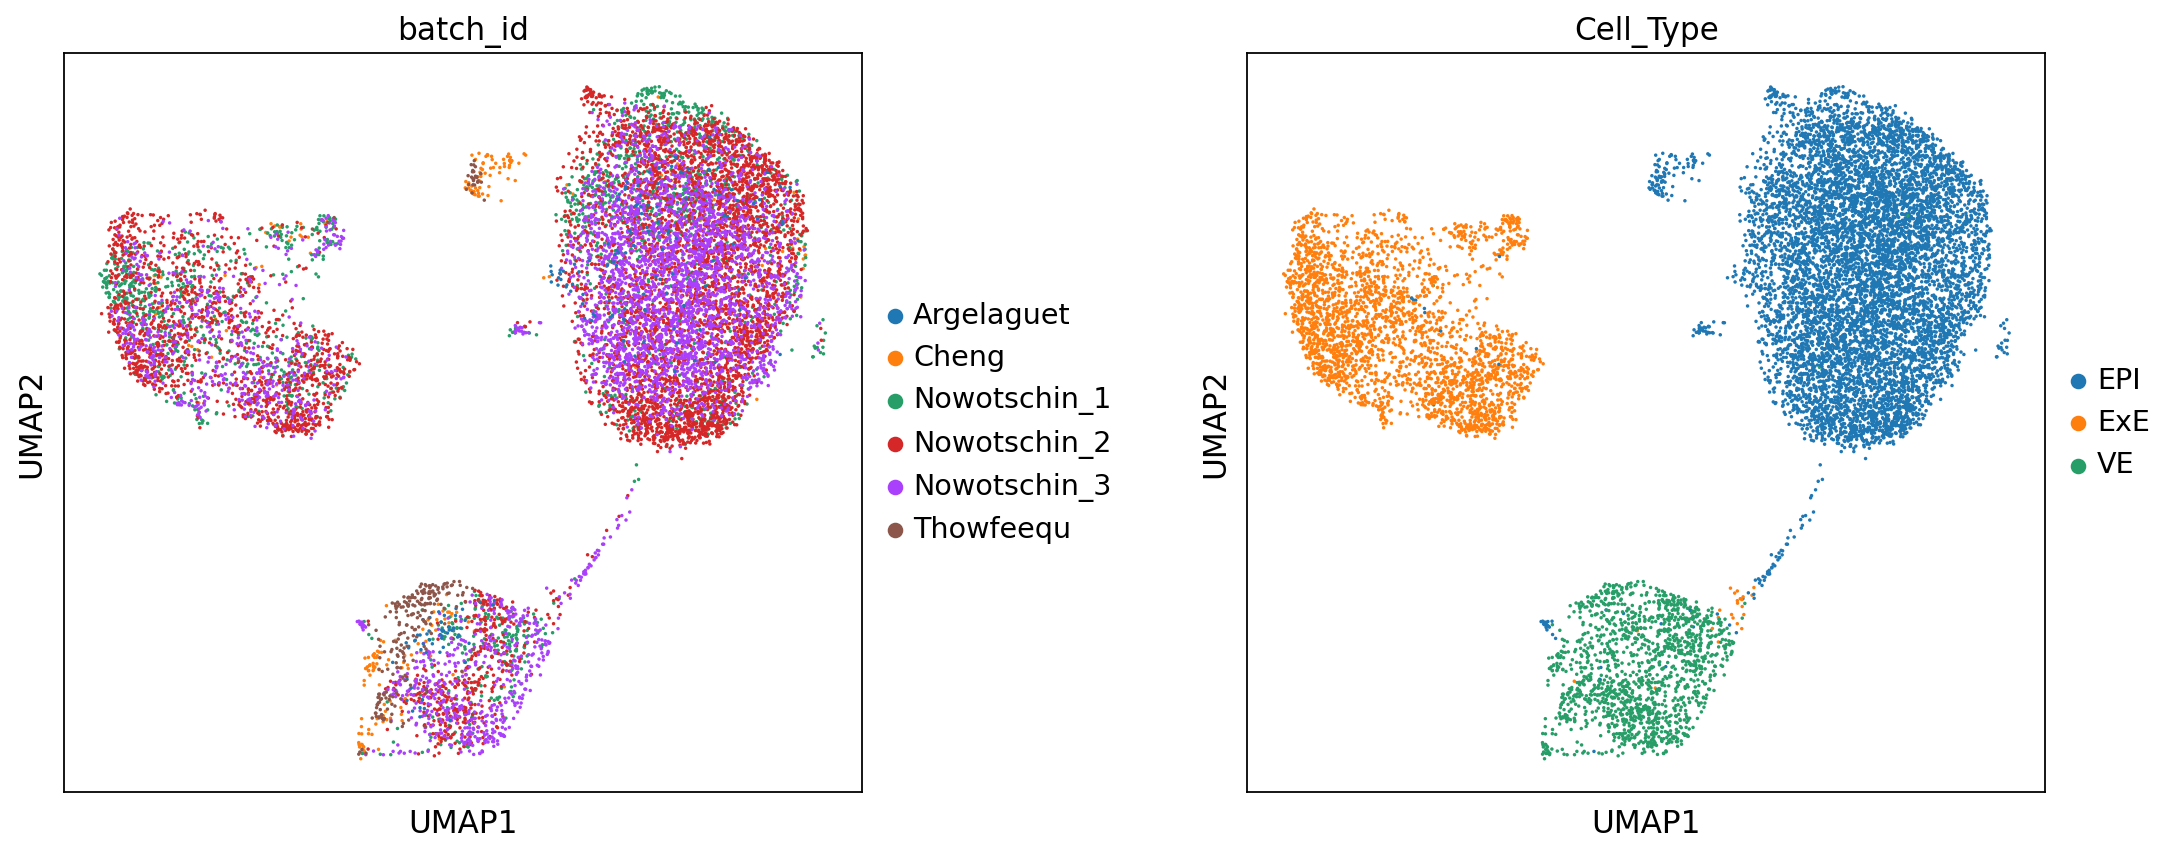

In [30]:
sc.set_figure_params(figsize=(6, 6))
sc.pl.umap(scanorama_integ_scran_data, color=["batch_id","Cell_Type"], ncols=3,wspace=0.35) #"clusters", 

### Scanorama with Scran-Cell Type Clusters

In [31]:
%%R 

size_factors_cell <- list()
len<- length(data_mats)

for(i in 1:len){
    data_mat <- data_mats[[i]]
    cell <- cell_types[[i]]
    size_factors_cell[[i]] = sizeFactors(
    computeSumFactors(
        SingleCellExperiment(
            list(counts=data_mat)), 
            clusters = cell
            # min.mean = 0.1,
            # BPPARAM = MulticoreParam()
    
    )
)
    
}

In [32]:
size_factors = ro.r("size_factors_cell")
size_factors = list(size_factors)

In [33]:
alldata_norm_scran_c = {key: adata.copy() for key, adata in alldata.items()}
for i,adata in enumerate(alldata_norm_scran_c):
    alldata_norm_scran_c[adata].obs["size_factors"] = size_factors[i] 
    scran = alldata_norm_scran_c[adata].X / alldata_norm_scran_c[adata].obs["size_factors"].values[:,None]
    alldata_norm_scran_c[adata].X = csr_matrix(sc.pp.log1p(scran))

In [34]:
adatas_scran_c =list(alldata_norm_scran_c.values())

In [35]:
for adata in adatas_scran_c:
    sc.pp.scale(adata, max_value=10) 

In [36]:
scanomrama_result_scran_c = scanorama_umap(adatas_scran_c)

Found 15456 genes among all datasets
[[0.         0.66542751 0.16728625 0.18215613 0.58333333 0.5204461 ]
 [0.         0.         0.92133205 0.54150579 0.36309524 0.02777778]
 [0.         0.         0.         0.87221202 0.30357143 0.01587302]
 [0.         0.         0.         0.         0.66666667 0.34126984]
 [0.         0.         0.         0.         0.         0.43253968]
 [0.         0.         0.         0.         0.         0.        ]]
Processing datasets (1, 2)
Processing datasets (2, 3)
Processing datasets (3, 4)
Processing datasets (0, 1)
Processing datasets (0, 4)
Processing datasets (1, 3)
Processing datasets (0, 5)
Processing datasets (4, 5)
Processing datasets (1, 4)
Processing datasets (3, 5)
Processing datasets (2, 4)
Processing datasets (0, 3)
Processing datasets (0, 2)


In [37]:
scanorama_integ_scran_data_c = scanomrama_result_scran_c[1]

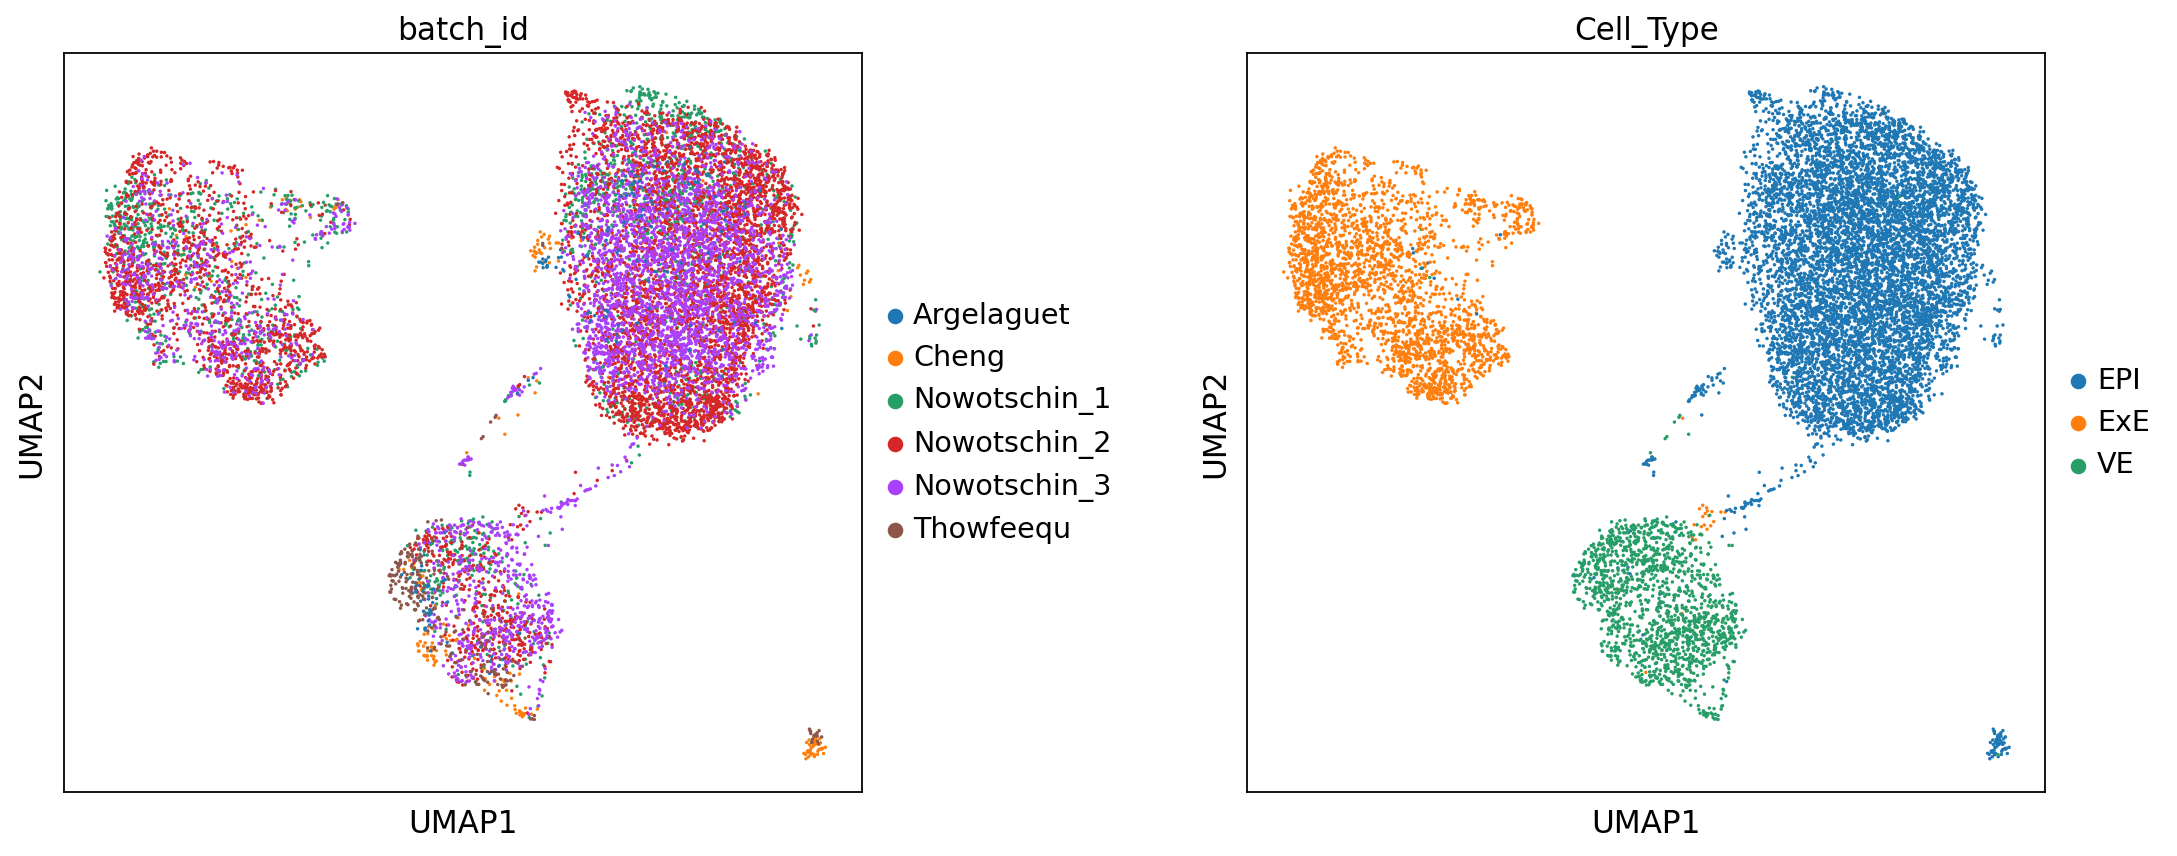

In [38]:
sc.set_figure_params(figsize=(6, 6))
sc.pl.umap(scanorama_integ_scran_data_c, color=["batch_id","Cell_Type"], ncols=3,wspace=0.35)

# Metrics

In [39]:
import scib

In [40]:
alldata_metric = {key: adata.copy() for key, adata in alldata.items()}
adatas_before=list(alldata_metric.values())
unintegrated = ad.concat(adatas_before, join='inner')
unintegrated.layers['counts'] = unintegrated.X.copy()
unintegrated.obs["batch_id"]= unintegrated.obs["batch_id"].astype('category')
unintegrated.obs["Cell_Type"]= unintegrated.obs["Cell_Type"].astype('category')

In [41]:
scanorama_integ_scanpy_data.obsm["X_scanorama"].shape

(12195, 100)

In [42]:
scanorama_integ_scran_data_c.obs["batch_id"]= scanorama_integ_scran_data_c.obs["batch_id"].astype('category')
scanorama_integ_scran_data_c.obs["Cell_Type"]= scanorama_integ_scran_data_c.obs["Cell_Type"].astype('category')
scanorama_integ_scanpy_data.obs["batch_id"]= scanorama_integ_scanpy_data.obs["batch_id"].astype('category')
scanorama_integ_scanpy_data.obs["Cell_Type"]= scanorama_integ_scanpy_data.obs["Cell_Type"].astype('category')
scanorama_integ_scran_data.obs["batch_id"]= scanorama_integ_scran_data.obs["batch_id"].astype('category')

In [ ]:
metrics_scanorama_scran_c = scib.metrics.metrics(unintegrated, scanorama_integ_scran_data_c, batch_key='batch_id', label_key='Cell_Type', embed='X_scanorama', cluster_key='cluster', cluster_nmi=None, ari_=True,
                        nmi_=True, nmi_method='arithmetic', nmi_dir=None, silhouette_=True, si_metric='euclidean', pcr_=True,
                        cell_cycle_=True, organism='mouse', hvg_score_=True, isolated_labels_=True, isolated_labels_f1_=True,
                        isolated_labels_asw_=True, n_isolated=None, graph_conn_=True, trajectory_= True, kBET_=True, lisi_graph_=True,
                        ilisi_=True, clisi_=True, subsample=0.5, n_cores=1, type_=None, verbose=True)

In [ ]:
metrics_scanorama_scanpy = scib.metrics.metrics(unintegrated, scanorama_integ_scanpy_data, batch_key='batch_id', label_key='Cell_Type', embed='X_scanorama', cluster_key='cluster', cluster_nmi=None, ari_=True,
                        nmi_=True, nmi_method='arithmetic', nmi_dir=None, silhouette_=True, si_metric='euclidean', pcr_=True,
                        cell_cycle_=True, organism='mouse', hvg_score_=True, isolated_labels_=True, isolated_labels_f1_=True,
                        isolated_labels_asw_=True, n_isolated=None, graph_conn_=True, trajectory_= True, kBET_=True, lisi_graph_=True,
                        ilisi_=True, clisi_=True, subsample=0.5, n_cores=1, type_=None, verbose=True)

metrics_scanorama_scran_l = scib.metrics.metrics(unintegrated, scanorama_integ_scran_data, batch_key='batch_id', label_key='Cell_Type', embed='X_scanorama', cluster_key='cluster', cluster_nmi=None, ari_=True,
                        nmi_=True, nmi_method='arithmetic', nmi_dir=None, silhouette_=True, si_metric='euclidean', pcr_=True,
                        cell_cycle_=True, organism='mouse', hvg_score_=True, isolated_labels_=True, isolated_labels_f1_=True,
                        isolated_labels_asw_=True, n_isolated=None, graph_conn_=True, trajectory_= True, kBET_=True, lisi_graph_=True,
                        ilisi_=True, clisi_=True, subsample=0.5, n_cores=1, type_=None, verbose=True)

In [ ]:
# metrics_scanorama_scanpy.to_csv("../metrics/Scanorama_scanpy.csv")
# metrics_scanorama_scran_l.to_csv("../metrics/Scanorama_scran_leiden.csv")
# metrics_scanorama_scran_c.to_csv("../metrics/Scanorama_scran_cell.csv")

In [46]:
metrics = pd.concat(
    [metrics_scanorama_scanpy, metrics_scanorama_scran_l,metrics_scanorama_scran_c],
    axis="columns",
)

In [47]:
metrics = metrics.set_axis(
    ["scanorama_scanpy", "scanorama_scran_leiden","scanorama_scran_cell_type"], axis="columns"
)

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

In [57]:
#Saving the data set with best metric scores.
#scanorama_integ_scran_data.write("Scanorama_scran_leiden.h5ad")

In [49]:
metrics

,scanorama_scanpy,scanorama_scran_leiden,scanorama_scran_cell_type
NMI_cluster/label,0.949508,0.920405,0.928710
ARI_cluster/label,0.979619,0.954557,0.962011
ASW_label,0.638604,0.644094,0.648272
ASW_label/batch,0.951613,0.964131,0.960591
PCR_batch,0.938846,0.935878,0.940201
cell_cycle_conservation,0.578359,0.543058,0.542413
isolated_label_F1,0.992886,0.993653,0.994037
isolated_label_silhouette,0.613325,0.635364,0.631549
graph_conn,0.998718,0.999730,0.999561
kBET,0.260688,0.193739,0.213510


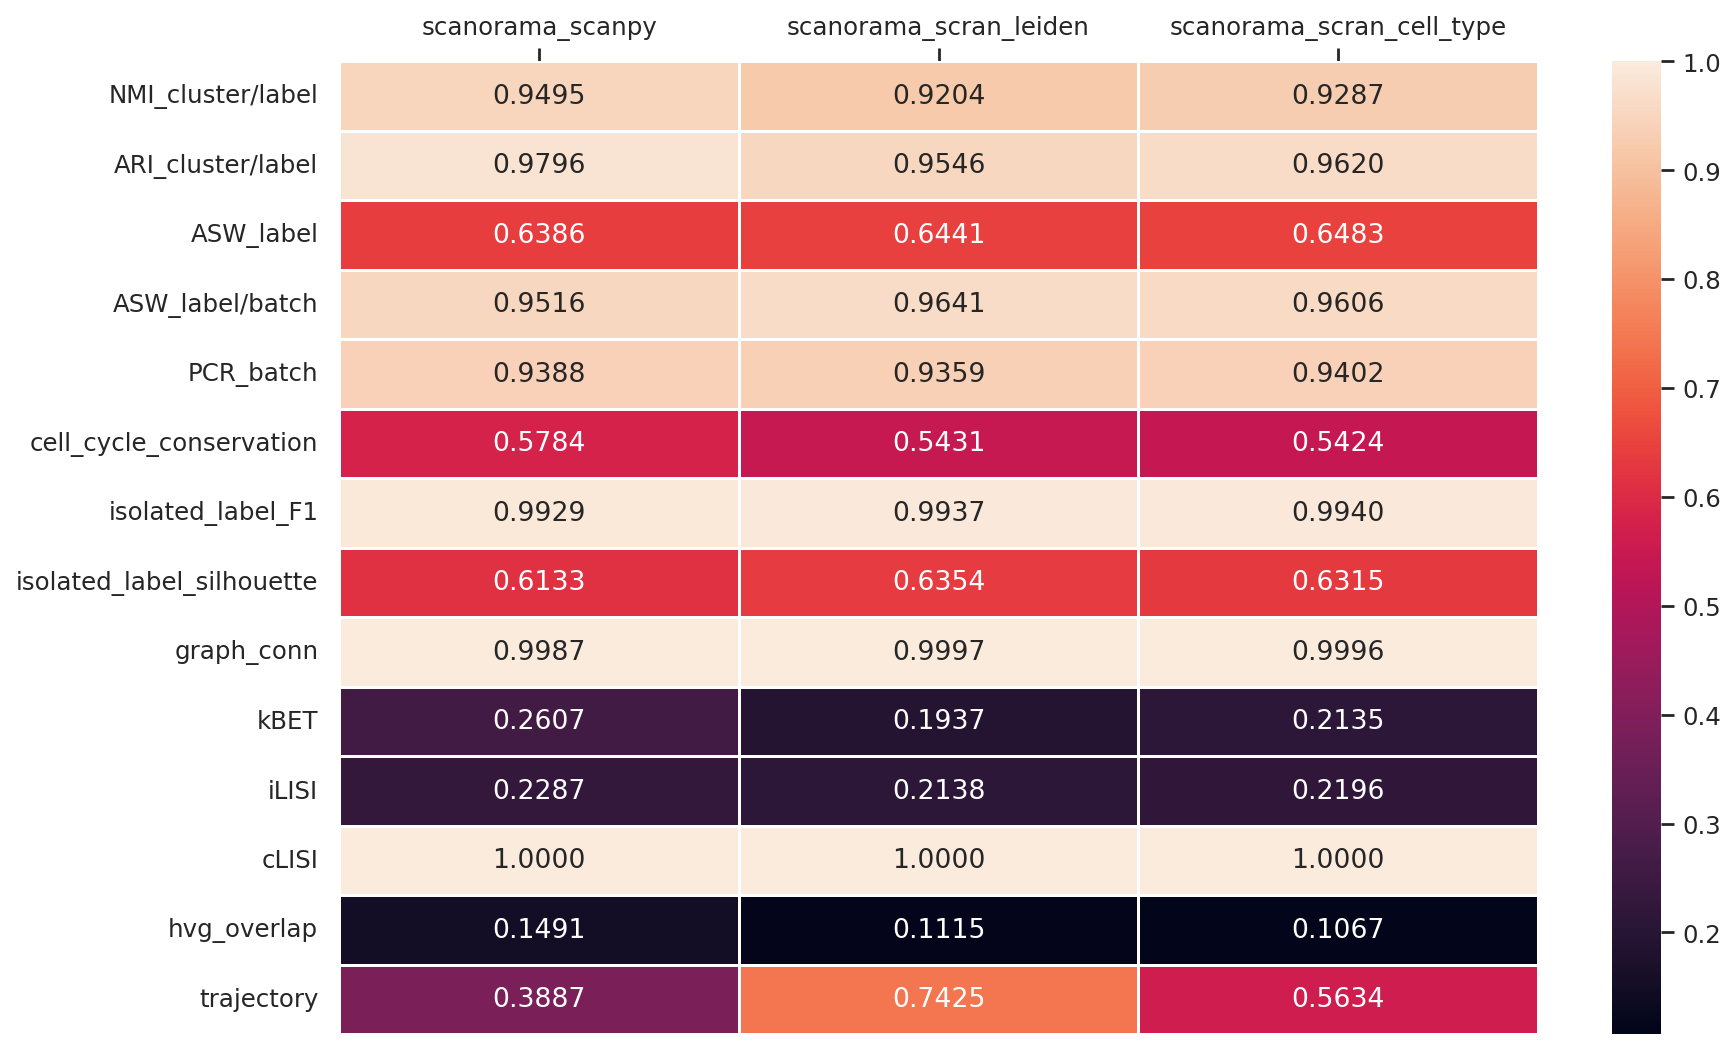

In [50]:
# df = pd.DataFrame(data=data)
# df = df.set_index('metric')

sns.set()
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(metrics, annot=True, fmt='.4f', linewidth=.5)
ax.xaxis.tick_top()
plt.savefig('Scanorama_metrics')
plt.show()
